#CNN

#Introducción

El problema que se plateó para este mini reto fue la identificación de animales marinos. El problema planteado es ayudar a los biólogos a la identificación de diferentes especies con el fin de poder diferenciarlas.

Esto permitirá a los investigadores poder identificar ejemplares de varias especies y de esta forma tener un control del número de población, aparición, ubicación, etc.

Es un tema relevante ya que tiene que ver con la protección y conservación de la fauna marina.

En esta parte se importan las librerías necesarias. Para esta CNN utilizaré Tensorflow y Keras.

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, shutil, pathlib
import numpy as np
import pandas as pd
import math

import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, BatchNormalization

%matplotlib inline

#Datos

El dataset se obtuvo de Kaaggle e incluye 23 categorias diferentes de animales marinos.Por cada categoría hay alrededor de 499 imágenes.

Inicialmente se empleó el API de Kaggle para obtener los datos y se alojaron dentro de los archivos de colab. Por cuestiones de experimentación, se agregó un pedazo de código que permite eliminar los files de colab.

Como las imagenes tenían nombres al azar, se cambiaron los nombre para permitir un mejor control de los datos.

En este caso, todas las imágenes se encontraban en un solo espacio, por lo que el siguiente paso que tomé fue dividirlo en tres partes. Train, test y validation. La distribución del dataset en estas tres seecciones fue 60% de los datos para el train, 20% para test y 20% para validación. De igual manera, se crearon batches de 32 con el fin de mejorar el procesamiento de las imágenes.

Finalmente se utilizó la función:

```
# x_dataset = image_dataset_from_directory()
```
para que las imágenes pudieran ser utilizadas para entrenar el modelo.



##Extracting and cleaning data from kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Check kaggle is working
!kaggle datasets list

ref                                                           title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset            Customer Shopping Trends Dataset                146KB  2023-10-05 06:45:37          24092        489  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset                LLM: 7 prompt training dataset                   31MB  2023-11-08 07:47:40            372         47  1.0              
bryanchungweather/nba-player-stats-dataset-for-the-2023-2024  NBA Player Stats Dataset for the 2023-2024       21KB  2023-11-14 03:53:32            662         27  1.0              
joebeachcapital/30000-spotify-songs                           30000 Spotify Songs         

In [3]:
#Download dataset
!kaggle datasets download -d vencerlanz09/sea-animals-image-dataste

 93% 289M/312M [00:02<00:00, 141MB/s]
100% 312M/312M [00:02<00:00, 114MB/s]


In [4]:
# #DELETE EVERYTHING IN CASE OF ERROR CHARGING (do not run)

# shutil.rmtree('/content/SeaAnimals')
# for animal in list_animals:
# # # Especifica la ruta del directorio que deseas limpiar
#   directory_to_clear = '/content/'+animal  # Cambia 'tu_directorio' con el nombre real de tu directorio

#   # # Utiliza el comando de sistema operativo para eliminar todos los archivos en el directorio
#   # os.system(f"rm -r {directory_to_clear}/*")
#   shutil.rmtree(directory_to_clear)


In [5]:
#unzip data
!unzip -qq sea-animals-image-dataste.zip

In [6]:
# Define the directory where the uploaded files are located
upload_dir = '/content/'  # This is the default directory for uploads in Colab

# Get a list of all files in the directory
uploaded_files = os.listdir(upload_dir)

list_animals = ['Clams', 'Corals', 'Crabs', 'Fish','Turtle_Tortoise', 'Lobster', 'Nudibranchs', 'Sharks', 'Sea Urchins', 'Starfish', 'Dolphin', 'Seal', 'Penguin', 'Otter', 'Puffers', 'Shrimp', 'Jelly Fish', 'Squid', 'Whale', 'Sea Rays', 'Seahorse', 'Octopus', 'Eel']

In [7]:
def change_folder_name(folder_name): #CHANGE IMAGES NAME
  # Specify the path to the folder containing the images
  folder_path = '/content/'+folder_name  # Change 'your_folder' to the actual folder name
  # Get a list of all files in the folder
  files = os.listdir(folder_path)

  # Iterate through the files and rename them
  for i, file_name in enumerate(files):
      # Specify the new name for each file (you can customize this logic)
      new_name = folder_name+f"_{i + 1}.jpg"
      # Construct the full paths for the old and new names
      old_path = os.path.join(folder_path, file_name)
      new_path = os.path.join(folder_path, new_name)
      # Rename the file
      os.rename(old_path, new_path)
  return()

#Get the list
for animal in list_animals:
  change_folder_name(animal)

##Creating train, test and validation sets

In [8]:
def make_subset(subset_name, start_index, end_index,category):#Create subsets
  dir = new_base_dir / subset_name / category
  os.makedirs(dir)
  fnames = [f"{category}_{i}.jpg"
            for i in range(start_index, end_index)]
  for fname in fnames:
      shutil.copyfile(src=original_dir / fname,
                      dst=dir / fname)

def len_folders(animal_name,percentaje): #Returns the percentage
  len_animal=len(os.listdir('/content/'+animal_name))
  return(math.ceil(len_animal*percentaje))

In [9]:
for animal in list_animals:
  original_dir = pathlib.Path(animal)
  new_base_dir = pathlib.Path("SeaAnimals")

  make_subset("train", start_index=1, end_index=len_folders(animal,.6),category=animal)
  make_subset("test", start_index=len_folders(animal,.6)+1, end_index=len_folders(animal,.8),category=animal)
  make_subset("validation", start_index=len_folders(animal,.8)+1, end_index=len(os.listdir('/content/'+animal)),category=animal)

In [10]:
len(os.listdir('/content/Clams')) #number of images in a folder

497

##Image manipulation (etiquetado y preparación)

In [11]:
train_dataset = image_dataset_from_directory(
    '/content/SeaAnimals/train',
    image_size=(200,200),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    '/content/SeaAnimals/test',
    image_size=(200,200),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    '/content/SeaAnimals/validation',
    image_size=(200,200),
    batch_size=32)

Found 8214 files belonging to 23 classes.
Found 2719 files belonging to 23 classes.
Found 2709 files belonging to 23 classes.


In [12]:
#GETTING THE LABELS FROM THE TEST DATASET
for images_test, labels_test in test_dataset:
    pass

In [13]:
#obtain labels
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 200, 200, 3)
labels batch shape: (32,)


#Desarrollo de modelo

Para la arquitectura del modelo 1, se emplearon las siguientes capas:
* Rescaling: Ajustar los valores de la imagen entr 0 y 1. Esto permite que las imágenes sean procesadas de mejor manera.
* Conv2D: Permiten extraer las características de la imagen
* MaxPooling: Ayudan a reducir la dimensionalidad de la imagen

Es importante mencionar que traté de poner estas dos capaz juntas. Mi propósito fue que a la ez que se identificaban patrones, la imagen pierde dimensionalidad y la caracterítica prevalece.

* Flatten: Ayuda a que la imagen pase a ser un vector
* Dense: La última capa densa con 23 neuronas permitirá que la imagen sea clasificada en una de las 23 categorías existentes.

Posteriormente se compiló el modelo y se especificaron dos métricas: Accuracy y MSE. Esto me permitirá identificar que tan bien va el modelo.

Para la parte de los callbacks se emplearon dos métodos.

1.   ModelCheckpoint: Permite guardar los pesos del mejor modelo.
2.   EarlyStopping: Dependiendo de la métrica que elijas, detiene el entrenamiento si es que no hay un incremento signwificativo. Por ejemplo: si elijo loss y pongo 20 épocas, estas se detendrán si el valor de loss no cambia en un determinado número de épocas.

Después se hace el fit del modelo, en donde se especifica el número de épocas y si hay callbacks, también se ponen.

Lo siguiente son las gráficas.


De las gráficas podemos observar que hay overfitting. Esto se puede indetificar debido a que las lineas de tendencia de training loss y validation los comienzan jutas y poco a poco se van separando.

En la gráfica del accuracy podemos ver que los puntajes fueron muy buenos en el entrenamiento pero al probarlos con el sset de validación, disminuyó mucho.

Esto indicca que el modelo no está generalizando y ses esta especializando o memorizando los patrones de las imágenes.

Para mejorar el desempeño del modelo realizaré data augmentation, pues desde el inicio se sabía que el dataset no era tan robusto.

Al último se muestran las métricas de accuracy y MSE.

##Model 1

In [98]:
model1 = keras.Sequential([keras.Input(shape=(200, 200, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(23, activation='softmax')])

model1.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_25 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_125 (Conv2D)         (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_123 (MaxPool  (None, 99, 99, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_126 (Conv2D)         (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_124 (MaxPool  (None, 48, 48, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_127 (Conv2D)         (None, 46, 46, 128)     

In [99]:
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','mse'])

In [25]:
#save weights
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10, restore_best_weights=True,  verbose=1)]

In [100]:
#Train model
history = model1.fit(train_dataset, epochs=10,
                    validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


257/257 [==============================] - 16s 58ms/step - loss: 2.6278 - accuracy: 0.2515 - mse: 187.1757 - val_loss: 2.5065 - val_accuracy: 0.2666 - val_mse: 187.4928
Epoch 2/10
257/257 [==============================] - 15s 57ms/step - loss: 2.1954 - accuracy: 0.3388 - mse: 187.1787 - val_loss: 2.3286 - val_accuracy: 0.3089 - val_mse: 187.4939
Epoch 3/10
257/257 [==============================] - 15s 57ms/step - loss: 1.8496 - accuracy: 0.4480 - mse: 187.1822 - val_loss: 2.8923 - val_accuracy: 0.3060 - val_mse: 187.5021
Epoch 4/10
257/257 [==============================] - 15s 57ms/step - loss: 1.2446 - accuracy: 0.6182 - mse: 187.1898 - val_loss: 2.6641 - val_accuracy: 0.3575 - val_mse: 187.5053
Epoch 5/10
257/257 [==============================] - 15s 57ms/step - loss: 0.6303 - accuracy: 0.8165 - mse: 187.2001 - val_loss: 3.3961 - val_accuracy: 0.3321 - val_mse: 187.5086
Epoch 6/10
257/257 [==============================] - 15s 57ms/step - loss: 0.3274 - accuracy: 0.9072 - mse: 18

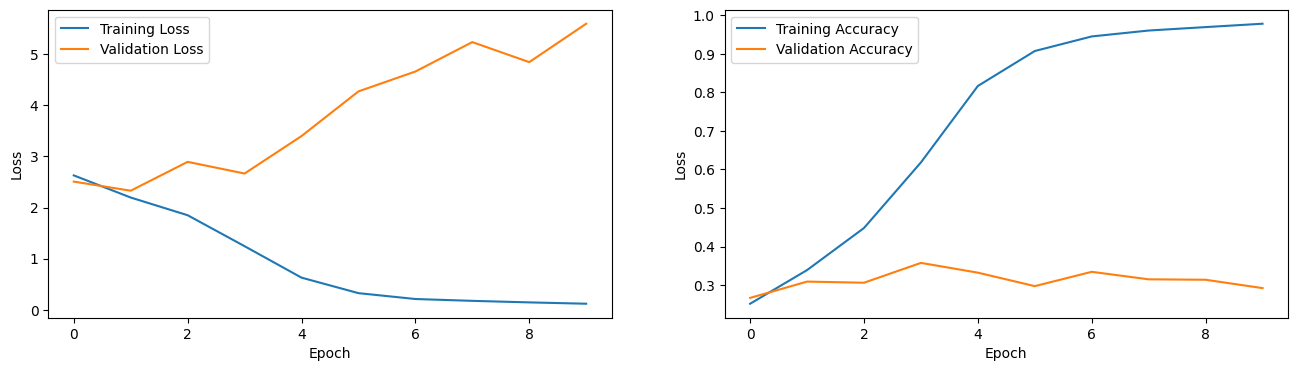

In [101]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [102]:
test_model1 = keras.models.load_model("convnet_from_scratch")
test_results1 = test_model1.evaluate(x=images_test, y=labels_test)
print("Test results:", test_results1)

test_loss1, test_acc1 ,test_mse1= test_results1
print(f"Test accuracy: {test_acc1:.3f}")
print(f"Test mse: {test_mse1:.3f}")


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 1s 548ms/step - loss: 1.6761 - accuracy: 0.4762 - mse: 224.5649
Test results: [1.6760740280151367, 0.4761904776096344, 224.56491088867188]
Test accuracy: 0.476
Test mse: 224.565


#Ajuste del modelo

Con el data augmentation, busco que el dataset para entrenar el modelo se amplie. Los diferentes filtros que se pueden aplicar sirven para distorcionar las imagenes de tal modo que se tomen como un dato nuevo.

Probé todos los filtro de la librería de Keras:
* RandomFlip: Gira la imagen
* RandomRotation: Rota la imagen
* RandomZoom: Hace un zoom
* RandomCrop: Corta la imagen al tamaño especificado
* RandomTraslation: Desplaza la imagen
* RandomContrast: Agrega contraste
* RandomBrightness: Aumenta el brillo



MODELO 2

A este nuevo modelo se le modificó la arquitectura para corregir overfitting.
* Se agregó la capa de data augmentation que permitirá al modelo tomar en cuenta las nuevas imágenes creadas a partir de los filtros anteriores
* Igualmente se agregaron capas de Dropout (promueve menos overfitting)
* Se agregaron dos capas Conv2D con 256 filtros y activación RELU.
* Conclusión del modelo: El Accuracy final no mejoró, sin embargo por las gráficas podemos ver que el modelo presenta menos overfitting pero sigue sin generalizar completamente. Esto se puede notar explícitamente cuando la línea de la gráfica baja y sube.

##Data augmentation

In [69]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.3),
                                      layers.RandomZoom(0.3),
                                      layers.RandomCrop(180,180),
                                      layers.RandomTranslation(.2,.2,fill_mode="nearest",interpolation="bilinear"),
                                      layers.RandomContrast(factor=0.6),
                                      layers.RandomBrightness(factor=0.4)],
                                      name='data_augmentation')

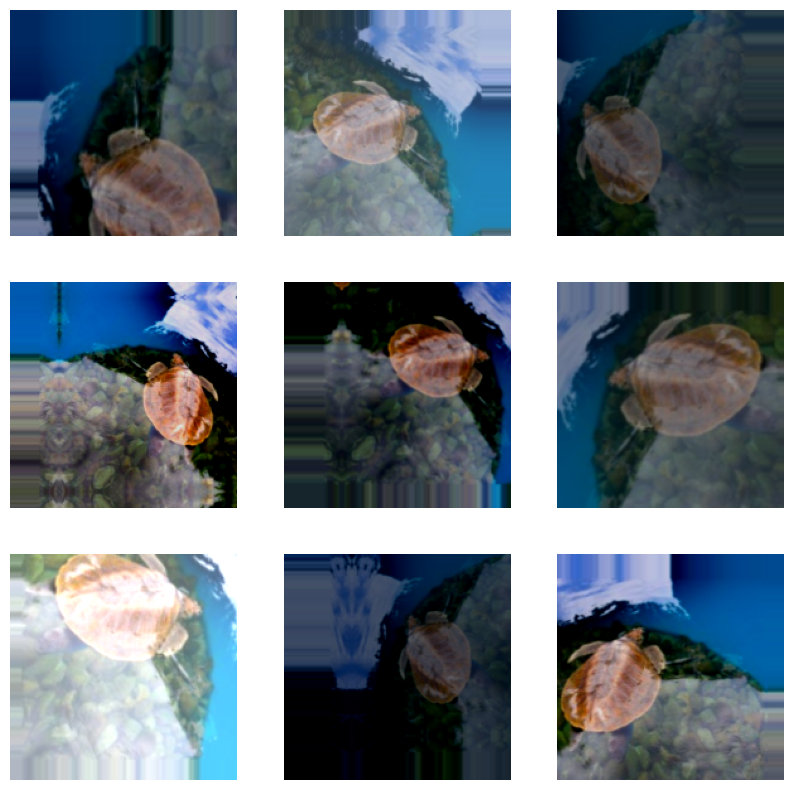

In [70]:
#Visualize the filters applied to the image
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

##Model 2

In [106]:
model2 = keras.Sequential([keras.Input(shape=(200, 200, 3)),
                          data_augmentation, #we add the new augmented data here
                          Rescaling(1./255),
                          Conv2D(filters=32, kernel_size=3, activation="relu"),
                          MaxPooling2D(pool_size=2),

                          Conv2D(filters=64, kernel_size=3, activation="relu"),
                          MaxPooling2D(pool_size=2),

                          Conv2D(filters=128, kernel_size=3, activation="relu"),
                          Dropout(0.5)
                          MaxPooling2D(pool_size=2),

                          Conv2D(filters=256, kernel_size=3, activation="relu"),
                          Dropout(0.5),
                          MaxPooling2D(pool_size=2),

                          Conv2D(filters=256, kernel_size=3, activation="relu"),
                          Dropout(0.5),
                          Flatten(),
                          layers.Dense(23, activation="softmax")])

model2.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 180, 180, 3)       0         
 ial)                                                            
                                                                 
 rescaling_27 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_133 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_129 (MaxPool  (None, 89, 89, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_134 (Conv2D)         (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_130 (MaxPool  (None, 43, 43, 64)      

In [107]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','mse'])

In [108]:
#Train model
history2 = model2.fit(train_dataset, epochs=50,
                    validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/50
257/257 [==============================] - 24s 82ms/step - loss: 2.8489 - accuracy: 0.1814 - mse: 187.1731 - val_loss: 2.7140 - val_accuracy: 0.2137 - val_mse: 187.4883
Epoch 2/50
257/257 [==============================] - 21s 80ms/step - loss: 2.7133 - accuracy: 0.2054 - mse: 187.1737 - val_loss: 2.6044 - val_accuracy: 0.2295 - val_mse: 187.4886
Epoch 3/50
257/257 [==============================] - 22s 86ms/step - loss: 2.6473 - accuracy: 0.2172 - mse: 187.1742 - val_loss: 2.6021 - val_accuracy: 0.2321 - val_mse: 187.4890
Epoch 4/50
257/257 [==============================] - 20s 76ms/step - loss: 2.6143 - accuracy: 0.2245 - mse: 187.1744 - val_loss: 2.4900 - val_accuracy: 0.2449 - val_mse: 187.4903
Epoch 5/50
257/257 [==============================] - 22s 83ms/step - loss: 2.5804 - accuracy: 0.2322 - mse: 187.1748 - val_loss: 2.5462 - val_accuracy: 0.2560 - val_mse: 187.4896
Epoch 6/50
257/257 [==============================] - 20s 76ms/step - loss: 2.5412 - accuracy: 0.245

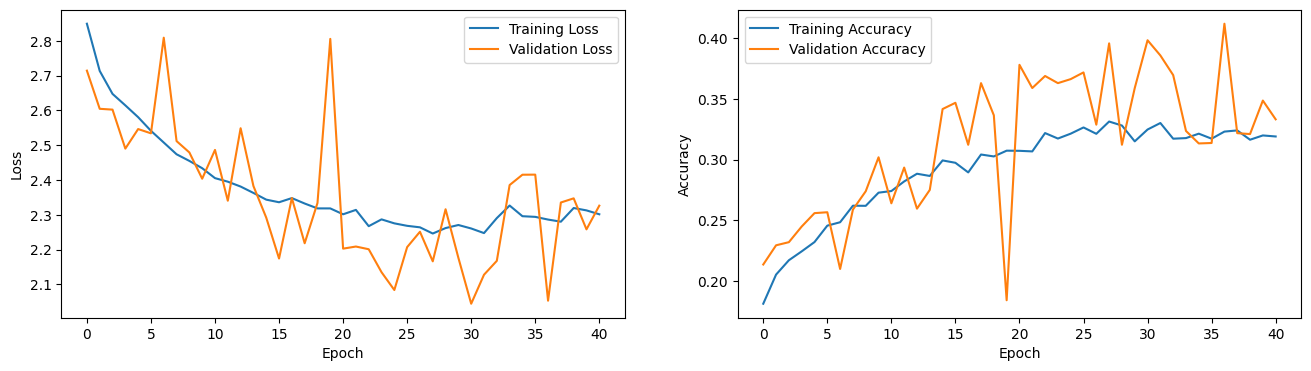

In [109]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [110]:
test_model2 = keras.models.load_model("convnet_from_scratch")
test_results2 = test_model2.evaluate(x=images_test, y=labels_test)
print("Test results:", test_results2)

test_loss2, test_acc2, test_mse2= test_results2
print(f"Test accuracy: {test_acc2:.3f}")
print(f"Test mse: {test_mse2:.3f}")

1/1 [==============================] - 0s 349ms/step - loss: 1.6761 - accuracy: 0.4762 - mse: 224.5649
Test results: [1.6760740280151367, 0.4761904776096344, 224.56491088867188]
Test accuracy: 0.476
Test mse: 224.565


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


#Resultados

Para el modelo final se realizaron algunos cambios para nuevamente prevenir el overfitting.

* Se disminuyeron las capas de Dropout de 3 a 2. Se colocaron en las dos últimas capas (excluyendo la capa de output)
* Algo que ayudó bastante fue agregar BatchValidation. Esto permitió que se normalizaran los datos en cada batch. El número de imágenes establecido por batch es de 32.
* Se ajustaron los hiperparámetros de la capa de aumento de datos. Se ajustó el modo en que las imágenes se llenan una vez que se realice la traslación, se reducjo el contraste y el brillo y se aumento la rotación y el zoom.
```
Nueva configuracaión del aumento de datos
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.3),
                                      layers.RandomZoom(0.3),**
                                      layers.RandomCrop(180,180),
                                      layers.RandomTranslation(.2,.2,fill_mode="nearest",interpolation="bilinear"),
                                      layers.RandomContrast(factor=0.6),
                                      layers.RandomBrightness(factor=0.4)],
                                      name='data_augmentation')
```
* En la parte del fit del modelo se aumentaron las épocas a 100.



##Modelo 3

In [41]:
model51 = keras.Sequential([keras.Input(shape=(200, 200, 3)),
                          data_augmentation, #we add the new augmented data here
                          Rescaling(1./255),

                          Conv2D(filters=32, kernel_size=3, activation="relu"),
                          MaxPooling2D(pool_size=2),

                          Conv2D(filters=64, kernel_size=3, activation="relu"),
                          MaxPooling2D(pool_size=2),

                          Conv2D(filters=128, kernel_size=3, activation="relu"),
                          BatchNormalization(),
                          MaxPooling2D(pool_size=2),

                          Conv2D(filters=256, kernel_size=3, activation="relu"),
                          BatchNormalization(),
                          MaxPooling2D(pool_size=2),
                          Dropout(0.5),

                          Conv2D(filters=256, kernel_size=3, activation="relu"),
                          BatchNormalization(),
                          MaxPooling2D(pool_size=2),
                          Dropout(0.5),

                          Flatten(),
                          layers.Dense(23, activation="softmax")])
model51.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 150, 150, 3)       0         
 ial)                                                            
                                                                 
 rescaling_8 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 36, 36, 64)       

In [42]:
model51.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','mse'])

In [43]:
#Train model
history51 = model51.fit(train_dataset, epochs=100,
                    validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


257/257 [==============================] - 20s 66ms/step - loss: 4.0086 - accuracy: 0.1057 - mse: 187.1795 - val_loss: 3.3172 - val_accuracy: 0.0647 - val_mse: 187.4899
Epoch 2/100
257/257 [==============================] - 17s 64ms/step - loss: 3.4215 - accuracy: 0.1550 - mse: 187.1767 - val_loss: 2.9643 - val_accuracy: 0.1607 - val_mse: 187.4905
Epoch 3/100
257/257 [==============================] - 20s 78ms/step - loss: 3.2304 - accuracy: 0.1629 - mse: 187.1759 - val_loss: 3.0947 - val_accuracy: 0.1758 - val_mse: 187.4900
Epoch 4/100
257/257 [==============================] - 17s 66ms/step - loss: 3.1215 - accuracy: 0.1697 - mse: 187.1752 - val_loss: 2.9865 - val_accuracy: 0.1633 - val_mse: 187.4909
Epoch 5/100
257/257 [==============================] - 17s 65ms/step - loss: 3.0434 - accuracy: 0.1791 - mse: 187.1750 - val_loss: 4.0628 - val_accuracy: 0.1372 - val_mse: 187.4930
Epoch 6/100
257/257 [==============================] - 17s 65ms/step - loss: 3.0331 - accuracy: 0.1855 - ms

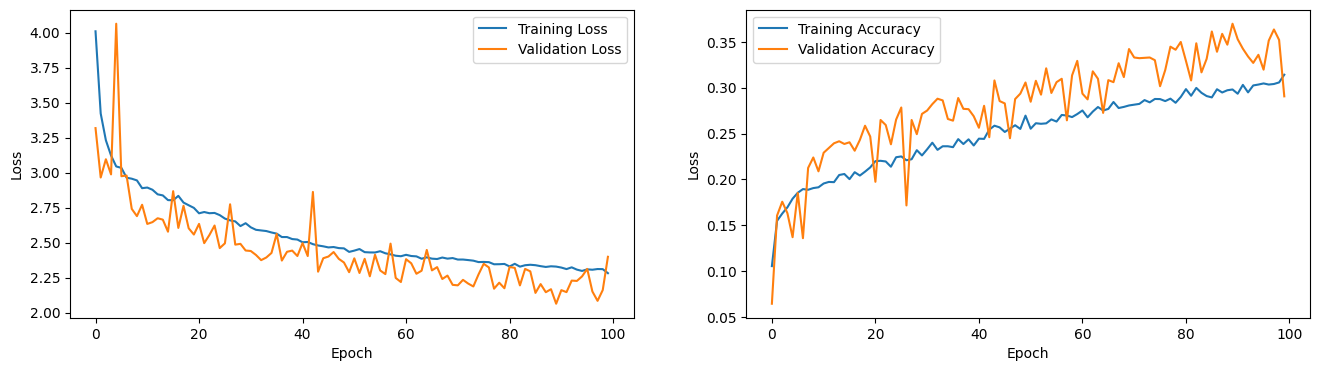

In [47]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history51.history['loss'], label='Training Loss')
plt.plot(history51.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history51.history['accuracy'], label='Training Accuracy')
plt.plot(history51.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [48]:
test_model51 = keras.models.load_model("convnet_from_scratch")
test_results51 = test_model51.evaluate(x=images_test, y=labels_test)
print("Test results:", test_results51)

test_loss51, test_acc51, test_mse51= test_results51
print(f"Test accuracy: {test_acc51:.3f}")
print(f"Test mse: {test_mse51:.3f}")



1/1 [==============================] - ETA: 0s - loss: 1.9008 - accuracy: 0.5238 - mse: 224.5612

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 0s 360ms/step - loss: 1.9008 - accuracy: 0.5238 - mse: 224.5612
Test results: [1.9007829427719116, 0.523809552192688, 224.5611572265625]
Test accuracy: 0.524
Test mse: 224.561


#Conclusiones

* **Resultados obtenidos**:

El resultado del último modelo fue mejor que los dos anteriores. Si bien no hubo una mejora grande en el accuracy, la gráfica nos presenta que el overfitting se redujo mucho. Ahora las líneas de training y validation están relativamente más cercanas. Podemos concluir que el BatchValidation ayudó al desempeño del modelo, así como las capas de dropout.

* **Áreas de mejora**

Considero que algunas áreas de mejora es agregar más imágenes al dataset, pues se sabía que la cantidad no era tanta. Aún con el aumento de datos, siempre es bueno tener buena cantidad y variedad de imágenes. También ayudaría saber si hay algún problema de bias. Considero que entrenar el modelo durante más épocas también sería interesante.